# Prévisions météo en Australie

## Consignes de l'itération 2 : "Modélisation"

	1. Ajouter les coordonnées géographiques (Australia Cities Database | Simplemaps.com)
	2. sélection des variables avec le test du chi2
	3. Extraction du jeu de données final
	4. Tableau des performances des algo avec et sans rééquilibrage
	5. Choisir une seconde stratégie pour l’itération 2 parmi les suivantes:
	• Classification des villes par clustering : création d'une nouvelle colonne catégorielle
    pour définir les différents types de climat selon les données climatique
	• Deep Learning
	• Séries Temporelles
	• Pluie J+3, J+7?
    
**Synchro** lundi 5 septembre à 17h \
**Deadline** dimanche 11 septembre
    
## Consignes de l'itération 3 : "Modélisation"

	1. Effectuer la même comparaison de performances sur la pluie à J+3 et J+7, et comparer.
	2. Explorer les stratégies "Deep Learning" ou "Séries Temporelles".
	3. Tester différentes variables cibles telles que le vent ou la température.

**Synchro** mercredi 28 septembre à 17h30 \
**Deadline** TBD

## Notes

	• Pour regrouper des données par longitude/latitude, ou même par température: 
    => https://www.kaggle.com/code/lykin22/weather-station-clustering-using-dbscan.
    • Pour les variables avec une forte proportion de valeurs manquantes, l’algorithme KNN-Imputer permet de remplacer les NANs en fonction des voisins:
    => https://www.youtube.com/watch?v=QVEJJNsz-eM.
    • Les variables avec moins de 10% de valeurs manquantes peuvent être traitées avec la méthode interpolate. 
	• Variables ignorées: 'Date', 'WindGustDir', 'WindDir9am' et 'WindDir3pm'.
	• Variables crées: 'Temp_Delta_MinMax', 'Humidity_Delta', 'clim_chaud_humide', 'clim_méditerranéen', 'clim_sec' et 'clim_tempéré_froid'.
	• Suppression des valeurs manquantes pour 'RainToday' et 'RainTomorrow'.

# Récupération des librairies

In [3]:
# récupération du package scikit-plot
!pip install scikit-plot

In [2]:
# récupération des librairies
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, datetime
import scikitplot as skplt

from scipy.spatial.distance import cdist
from scipy.stats import chi2_contingency

from sklearn import ensemble, linear_model, model_selection, neighbors, preprocessing, svm

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier, Lasso, LassoCV, lasso_path, RidgeCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, mean_squared_error, recall_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, learning_curve, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler

# Modèles de classification par apprentissage supervisé

In [ ]:
# chargement des données en local
from google.colab import files
uploaded = files.upload()

In [3]:
# récupération du jeu de données sauvegardé
df = pd.read_csv('weatherAUS_preprocessed.csv', index_col=0)
df.head()

,MaxTemp,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainToday,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid
0,22.9,0.6,0.15000,44.0,22.0,1007.7,8.00000,21.8,0,0,9.5,-49.0,1,0,0,0
1,25.1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,0,0,17.7,-19.0,1,0,0,0
2,25.7,0.0,11.70000,46.0,30.0,1007.6,2.00000,23.2,0,0,12.8,-8.0,1,0,0,0
3,28.0,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,0,0,18.8,-29.0,1,0,0,0
4,32.3,1.0,2.55000,41.0,33.0,1010.8,8.00000,29.7,0,0,14.8,-49.0,1,0,0,0


In [4]:
#récupération du jeu de données sur Gdrive
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datascientest/Meteo/weatherAUS_preprocessed.csv')
# df.head()

In [6]:
select_feats = ['MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm',
       'Pressure9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'Temp_Delta_MinMax',
       'Humidity_Delta', 'clim_méditerranéen', 'clim_sec']

In [7]:
# séparation des données en une matrice de données et en un vecteur cible
data = df[select_feats]
target = df['RainTomorrow']

In [8]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state=123)

In [9]:
# distribution de la variable cible dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.777988
1    0.222012
Name: RainTomorrow, dtype: float64

In [10]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts(normalize=True)

0    0.779956
1    0.220044
Name: RainTomorrow, dtype: float64

In [11]:
# oversampling des données
# rOs = RandomOverSampler()
# X_ro, y_ro = rOs.fit_resample(X_train, y_train)
# print("Classes échantillon oversampled :", dict(pd.Series(y_ro).value_counts()))

In [12]:
# undersampling des données
rUs = RandomUnderSampler()
X_train_ru, y_train_ru = rUs.fit_resample(X_train, y_train)
print("Classes échantillon undersampled :", dict(pd.Series(y_train_ru).value_counts()))

Classes échantillon undersampled : {0: 25005, 1: 25005}


In [13]:
# distribution de la variable cible dans l'ensemble de test
y_train_ru.value_counts(normalize=True)

0    0.5
1    0.5
Name: RainTomorrow, dtype: float64

In [14]:
# paramètre à initialiser pour calculer les performances des algo avec et sans rééquilibrage
param_ru = ''

if param_ru == 'under_sample':
    X_train = X_train_ru
    y_train = y_train_ru

In [15]:
# standardisation des données
scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Régression Logistique

In [16]:
# définition du modèle
clf_lr  = LogisticRegression()

param_grid_lr = {'solver' : ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'], 
                 'C' : np.linspace(0.1,1,10)}

gcv_lr = GridSearchCV(clf_lr, param_grid_lr, cv=3)

In [17]:
start_time = time.time()

# entraînement (~ 25 sec.)
gcv_lr.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_lr.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_lr.best_params_, "\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_lr.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_lr.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'C': 0.1, 'solver': 'lbfgs'} 

Accuracy Score: 0.8435258185950707 

Train Data Score: 0.8394995960187873
Test Data Score: 0.8435258185950707

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            20726  1236
1             3170  3026

               precision    recall  f1-score   support

           0       0.87      0.94      0.90     21962
           1       0.71      0.49      0.58      6196

    accuracy                           0.84     28158
   macro avg       0.79      0.72      0.74     28158
weighted avg       0.83      0.84      0.83     28158

Running Time: 0:01:15.240531


- la méthode de régression logistique ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.76.
- la spécificité (taux de vrais négatifs) vaut 0.79.
- le F1-score concernant la classe '0' de la variable RainTomorrow est bon (0.85).
- le F1-score concernant la classe '1' de la variable RainTomorrow est faible (0.61).

In [18]:
cv_scores = cross_val_score(gcv_lr, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.83826546 0.83930426 0.84116879]
Average cross-validation score: 0.839579504390521


- Le score de la méthode de régression logistique est en moyenne de : 0.77.

In [19]:
pd.DataFrame([f1_score(y_test, y_pred),recall_score(y_test, y_pred),precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], columns=['scores_clf_lr_' + param_ru]).to_csv('scores_clf_lr_' + param_ru + '.csv')

In [102]:
# courbe ROC (Receiver Operaing Characteristic) pour le modèle de régression logistique
y_pred_logreg_proba = gcv_lr.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_logreg_proba[:,1])

In [103]:
# aire sous la courbe ROC
roc_auc = auc(fpr, tpr)
print("Aire sous la courbe =", roc_auc)

Aire sous la courbe = 0.8556330557229287


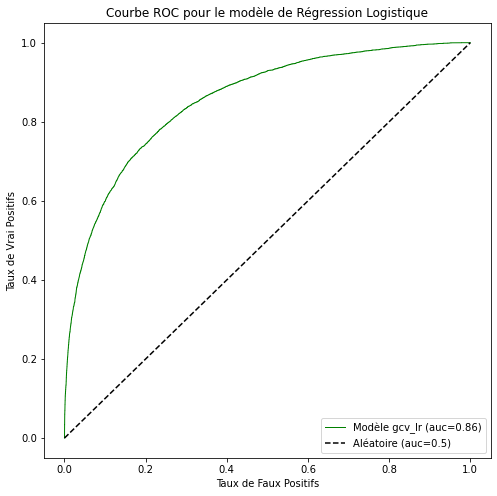

In [104]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, '-g', linewidth=1, label='Modèle gcv_lr (auc=%0.2f)' %roc_auc)
plt.plot([0,1], [0,1], 'k--', label='Aléatoire (auc=0.5)')
plt.title('Courbe ROC pour le modèle de Régression Logistique')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrai Positifs')
plt.legend(loc="lower right");


- La courbe ROC est l'outil idéal pour résumer la performance d'un classifieur binaire en fonction de tous les seuils possibles. Elle évite un long travail de prédictions de classes pour différents seuils, et d'évaluation de la matrice de confusion pour chacun de ces seuils.
- Graphiquement, la mesure ROC est représentée sous la forme d'une courbe qui donne le taux de vrais positifs (la sensibilité), en fonction du taux de faux positifs (l'antispécificité).
- Plus la courbe se rapproche du point (0,1), meilleures sont les prédictions. Un modèle avec une sensibilité et une spécificité égales à 1 est considéré comme parfait.



## Forêts Aléatoires

In [20]:
# définition du modèle
clf_rf  = RandomForestClassifier() # les forêts aléatoires ne gèrent pas les variables qualitatives

param_grid_rf  = [{'n_estimators' : [10, 50, 100],
                   'min_samples_leaf' : np.arange(1,6,1),
                   'max_features' : ['sqrt', 'log2']}]

gcv_rf = GridSearchCV(clf_rf, param_grid_rf)

In [21]:
start_time = time.time()

# entraînement (~ 6 min.)
gcv_rf.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_rf.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_rf.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_rf.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_rf.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 100} 

Accuracy Score: 0.8552454009517722 

Train Data Score: 0.9431940264052775
Test Data Score: 0.8552454009517722

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            20960  1002
1             3074  3122
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     21962
           1       0.76      0.50      0.61      6196

    accuracy                           0.86     28158
   macro avg       0.81      0.73      0.76     28158
weighted avg       0.85      0.86      0.84     28158

Running Time: 0:16:58.268273


- la méthode de forêt aléatoire fait l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.79.
- la spécificité (taux de vrais négatifs) vaut 0.81.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.87).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.64).

In [107]:
# temps d'exécution : ~ 18 min.
cv_scores = cross_val_score(gcv_rf, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.77954409 0.78356329 0.7845231 ]
Average cross-validation score: 0.7825434913017396


- Le score de la méthode des forêts aléatoires est en moyenne de : 0.80.

In [22]:
pd.DataFrame([f1_score(y_test, y_pred),recall_score(y_test, y_pred),precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], columns=['scores_clf_rf_' + param_ru]).to_csv('scores_clf_rf_' + param_ru + '.csv')

In [109]:
# probabilités pour X_test_scaled d'appartenir à chacune des deux classes
y_probas = gcv_rf.predict_proba(X_test_scaled)

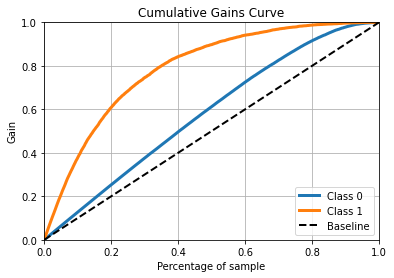

In [110]:
# courbe de gain cumulée
skplt.metrics.plot_cumulative_gain(y_test, y_probas);

- L'axe horizontal représente les individus de l'échantillon test.
- L'axe vertical représente la variable cible 'RainTomorrow'.

## Support Vector Machine

In [111]:
# définition du modèle
clf_svm = svm.SVC()

# le temps de calcul est élevé lors d'une régularisation des paramètres de la fonction noyau
param_grid_svm = {'kernel' : ['rbf','linear','poly'],
                  'gamma' : [0.001, 0.1, 0.5]}

gcv_svm = GridSearchCV(clf_svm, param_grid_svm)

In [112]:
start_time = time.time()

# entraînement (~ 1h)
grille = gcv_svm.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_svm.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_svm.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_svm.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_svm.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'gamma': 0.1, 'kernel': 'rbf'} 

Accuracy Score: 0.7958306697918887 

Train Data Score: 0.7916016796640671
Test Data Score: 0.7958306697918887

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            17595  4367
1             1382  4814
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     21962
           1       0.52      0.78      0.63      6196

    accuracy                           0.80     28158
   macro avg       0.73      0.79      0.74     28158
weighted avg       0.84      0.80      0.81     28158

Running Time: 3:34:36.021946


- la méthode SVM fait l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.79.
- la spécificité (taux de vrais négatifs) vaut 0.79.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.86).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.63).

In [113]:
cv_scores = cross_val_score(gcv_svm, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.78008398 0.78374325 0.78314337]
Average cross-validation score: 0.7823235352929414


- Le score de la méthode SVM est en moyenne de : 0.79.

In [114]:
pd.DataFrame([f1_score(y_test, y_pred),recall_score(y_test, y_pred),precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], columns=['scores_clf_svm_' + param_ru]).to_csv('scores_clf_svm_' + param_ru + '.csv')

In [115]:
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params','mean_test_score']])

                                 params  mean_test_score
0     {'gamma': 0.001, 'kernel': 'rbf'}         0.771426
1  {'gamma': 0.001, 'kernel': 'linear'}         0.770646
2    {'gamma': 0.001, 'kernel': 'poly'}         0.691122
3       {'gamma': 0.1, 'kernel': 'rbf'}         0.782224
4    {'gamma': 0.1, 'kernel': 'linear'}         0.770646
5      {'gamma': 0.1, 'kernel': 'poly'}         0.774245
6       {'gamma': 0.5, 'kernel': 'rbf'}         0.782004
7    {'gamma': 0.5, 'kernel': 'linear'}         0.770646
8      {'gamma': 0.5, 'kernel': 'poly'}         0.778784


In [116]:
# courbe d'apprentissage du modèle (prend beaucoup trop de temps)
# train_sizes, train_scores, valid_scores = learning_curve(svm.SVC(kernel='linear', C=1), data, target, train_sizes=[50, 80, 110, 140], cv=5)
# plt.xlabel("Training examples")
# plt.ylabel("Score")

# train_sizes = [50, 70, 80, 100, 110, 118]
# train_sizes, train_scores, test_scores = learning_curve(gcv_svm, data, target, n_jobs=4, train_sizes=train_sizes)

# train_score_mean = np.mean(train_scores, axis=1)
# train_score_std = np.std(train_scores, axis=1)
# test_score_mean = np.mean(test_scores, axis=1)
# test_score_std = np.std(test_scores, axis=1)

# plt.grid()
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# plt.legend(loc="best");

## K-plus proches voisins

In [23]:
# définition du modèle
clf_knn = neighbors.KNeighborsClassifier()

param_grid_knn = {'n_neighbors' : np.arange(1,41,1),
                  'metric' : ['minkowski','manhattan','chebyshev']}

gcv_knn = GridSearchCV(clf_knn, param_grid_knn)

In [24]:
start_time = time.time()

# entraînement (~ 20 min.)
gcv_knn.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_knn.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_knn.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_knn.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_knn.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'metric': 'manhattan', 'n_neighbors': 39} 

Accuracy Score: 0.8520846651040557 

Train Data Score: 0.8537321648953644
Test Data Score: 0.8520846651040557

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            21012   950
1             3215  2981
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     21962
           1       0.76      0.48      0.59      6196

    accuracy                           0.85     28158
   macro avg       0.81      0.72      0.75     28158
weighted avg       0.84      0.85      0.84     28158

Running Time: 3:01:31.312568


- la méthode des K-plus proches voisins ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.77.
- la spécificité (taux de vrais négatifs) vaut 0.80.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.86).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.62).

In [120]:
# temps de calcul : ~ 35 min.
cv_scores = cross_val_score(gcv_knn, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.77240552 0.774985   0.77780444]
Average cross-validation score: 0.7750649870025995


- Le score de la méthode KNN est en moyenne de : 0.78.

In [25]:
pd.DataFrame([f1_score(y_test, y_pred),recall_score(y_test, y_pred),precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], columns=['scores_clf_knn_' + param_ru]).to_csv('scores_clf_knn_' + param_ru + '.csv')

In [122]:
# scores de 3 modèles utilisant respectivement les matrices de Minkowski, Manhattan et Chebyshev pour des valeurs de k allant de 1 à 40
# temps de calcul : ~ 12 min.
score_minko = []
score_man = []
score_cheb = []

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_scaled, y_train)
  score_minko.append(knn.score(X_test_scaled, y_test))

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='manhattan')
  knn.fit(X_train_scaled, y_train)
  score_man.append(knn.score(X_test_scaled, y_test))

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
  knn.fit(X_train_scaled, y_train)
  score_cheb.append(knn.score(X_test_scaled, y_test))

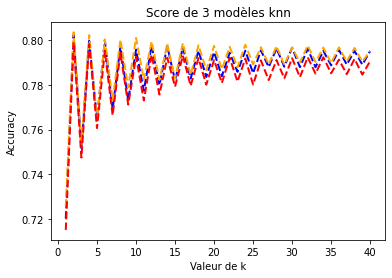

In [123]:
# affichage des listes crées en fonction de k
plt.title("Score de 3 modèles knn")
plt.plot(range(1,41), score_minko, color='blue', linestyle='dashed', lw=2, label='Minkowski')
plt.plot(range(1,41), score_man, color='orange', linestyle='dashed', lw=2, label='Manhattan')
plt.plot(range(1,41), score_cheb, color='red', linestyle='dashed', lw=2, label='Chebyshev')
plt.xlabel("Valeur de k")
plt.ylabel("Accuracy")
plt.legend;

## Arbres de décision

In [26]:
# définition du modèle
clf_dt = DecisionTreeClassifier()

param_grid_dt = {'criterion' : ['entropy','gini'], 
                 'max_depth' : np.arange(2,6,1)}

gcv_dt = GridSearchCV(clf_dt, param_grid_dt)

In [27]:
start_time = time.time()

# entraînement
gcv_dt.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_dt.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_dt.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_dt.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_dt.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'criterion': 'gini', 'max_depth': 5} 

Accuracy Score: 0.8392996661694723 

Train Data Score: 0.8385140594340712
Test Data Score: 0.8392996661694723

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            20828  1134
1             3391  2805
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     21962
           1       0.71      0.45      0.55      6196

    accuracy                           0.84     28158
   macro avg       0.79      0.70      0.73     28158
weighted avg       0.83      0.84      0.83     28158

Running Time: 0:00:08.332925


- la méthode des arbres de décision ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.75.
- la spécificité (taux de vrais négatifs) vaut 0.77.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.84).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.59).

In [126]:
# importance des variables
clf_dt = gcv_dt.best_estimator_
clf_dt.fit(X_train_scaled,y_train)

feats = {}
for feature, importance in zip(df.columns, clf_dt.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

,Importance
Humidity3pm,0.675205
Sunshine,0.115665
WindGustSpeed,0.087159
Pressure9am,0.073247
Rainfall,0.039847
Humidity_Delta,0.003427
Temp_Delta_MinMax,0.002319
MaxTemp,0.001718


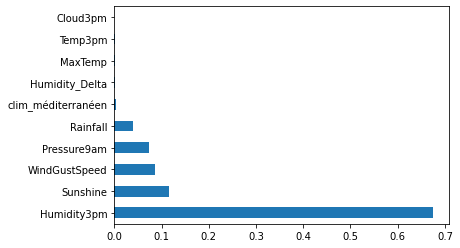

In [127]:
# importance des variables
feature_imp = pd.Series(clf_dt.feature_importances_,index=data.columns)
feature_imp.nlargest(10).plot(kind='barh');

In [128]:
cv_scores = cross_val_score(gcv_dt, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.75938812 0.75944811 0.755009  ]
Average cross-validation score: 0.7579484103179364


- Le score de la méthode DT est en moyenne de : 0.76.

In [28]:
pd.DataFrame([f1_score(y_test, y_pred),recall_score(y_test, y_pred),precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], columns=['scores_clf_dt_' + param_ru]).to_csv('scores_clf_dt_' + param_ru + '.csv')

# Résumé des performances

In [136]:
scores_clf_dt_under_sample = pd.read_csv('scores_clf_dt_under_sample.csv', index_col=0)
scores_clf_knn_under_sample = pd.read_csv('scores_clf_knn_under_sample.csv', index_col=0)
scores_clf_svm_under_sample = pd.read_csv('scores_clf_svm_under_sample.csv', index_col=0)
scores_clf_rf_under_sample = pd.read_csv('scores_clf_rf_under_sample.csv', index_col=0)
scores_clf_lr_under_sample = pd.read_csv('scores_clf_lr_under_sample.csv', index_col=0)

In [141]:
result_under_sample = pd.concat([scores_clf_dt_under_sample, scores_clf_knn_under_sample,scores_clf_svm_under_sample,
                    scores_clf_rf_under_sample,scores_clf_lr_under_sample], axis=1)

In [142]:
result_under_sample

,scores_clf_dt_under_sample,scores_clf_knn_under_sample,scores_clf_svm_under_sample,scores_clf_rf_under_sample,scores_clf_lr_under_sample
f1,0.592391,0.617278,0.626130,0.621807,0.601462
recall,0.736281,0.773241,0.776953,0.783731,0.763719
precision,0.495546,0.513670,0.524344,0.515335,0.496069


In [29]:
scores_clf_dt_ = pd.read_csv('scores_clf_dt_.csv', index_col=0)
scores_clf_knn_ = pd.read_csv('scores_clf_knn_.csv', index_col=0)
scores_clf_rf_ = pd.read_csv('scores_clf_rf_.csv', index_col=0)
scores_clf_lr_ = pd.read_csv('scores_clf_lr_.csv', index_col=0)

In [30]:
result_ = pd.concat([scores_clf_dt_, scores_clf_knn_,
                    scores_clf_rf_,scores_clf_lr_], axis=1)

In [31]:
result_

,scores_clf_dt_,scores_clf_knn_,scores_clf_rf_,scores_clf_lr_
f1,0.553527,0.588723,0.605039,0.578696
recall,0.452711,0.481117,0.503873,0.488380
precision,0.712110,0.758331,0.757032,0.709995
